In [1]:
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
draw_n_days = 400
df = hl.df_init(filename)

Current file path is /Users/kai/Desktop/qs/data_csv_distinct_0606/000002.SZ.csv


Current file path is /Users/kai/Desktop/qs/data_csv_distinct_0606/000002.SZ.csv


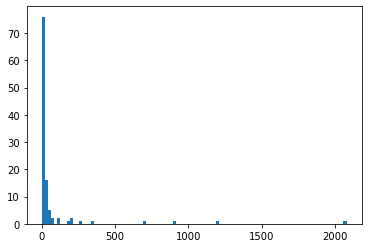

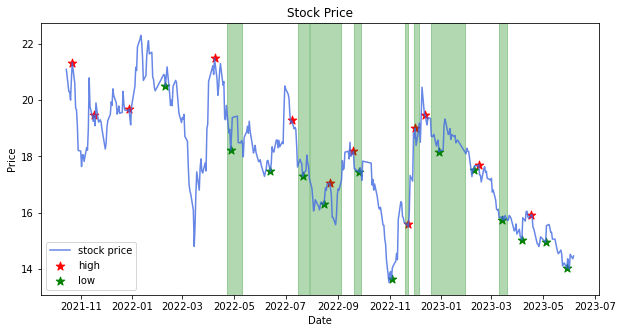

(111, 7912.0)

In [2]:
filename = '000002.SZ.csv'
df = hl.df_init(filename)
_, _, high_points, low_points = hl.find_high_low_old(df, filename=filename, save_data = False, draw_n_days=200, draw=False)
result = ha.find_ha_near_hl(df, high_points, low_points)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=400, print_result=False, show_plot=True, save_plot=False)

Current file path is /Users/kai/Desktop/qs/data_csv_distinct_0606/000002.SZ.csv


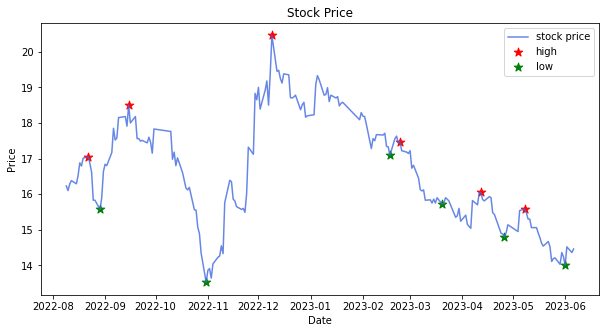

当前参数组合: max_len_of_window = 40, min_len_of_window = 5, gamma = 0.4


100%|██████████| 5676/5676 [00:18<00:00, 307.62it/s]


In [38]:
filename = '000002.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_high_low(df, filename=filename, save_data = False, draw_n_days=200, draw=True)
result, high_freq_ratio_list = ha.find_horizontal_area(df, high_points, low_points, 40, 5, ignore_hl=False)

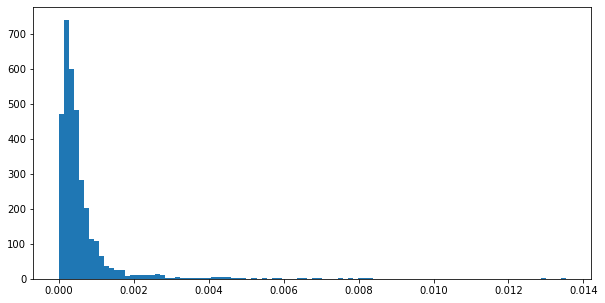

235 41 8


In [39]:
# 展示high_freq_ratio_list的分位数
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.hist(high_freq_ratio_list, bins=100)
plt.show()
# 把return按照return['interval']分为0-10, 10-40, >40三组
result_10 = []
result_40 = []
result_100 = []
for i in range(len(result)):
    if result.iloc[i]['interval'] <= 10:
        result_10.append(result.iloc[i])
    elif result.iloc[i]['interval'] <= 40:
        result_40.append(result.iloc[i])
    else:
        result_100.append(result.iloc[i])
print(len(result_10), len(result_40), len(result_100))
result_10 = pd.DataFrame(result_10)
result_40 = pd.DataFrame(result_40)
result_100 = pd.DataFrame(result_100)
result_10 = result_10[result_10['high_freq_ratio'] < np.percentile(result_10['high_freq_ratio'], 45)]
result_40 = result_40[result_40['high_freq_ratio'] < np.percentile(result_40['high_freq_ratio'], 75)]
result_100 = result_100[result_100['high_freq_ratio'] < np.percentile(result_100['high_freq_ratio'], 75)]
result_tt = pd.concat([result_10, result_40, result_100])

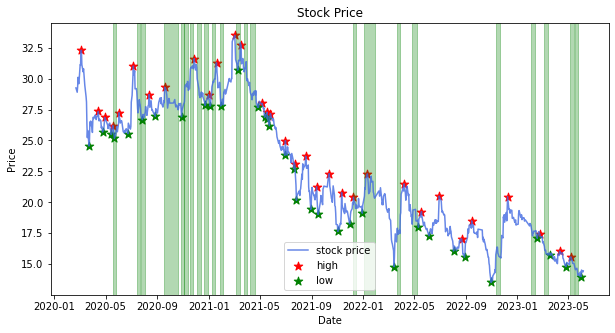

(142, 1832)

In [42]:
ha.draw_horizontal_area(df, result_tt, high_points, low_points, filename, n_days=800, print_result=False, show_plot=True, save_plot=False)

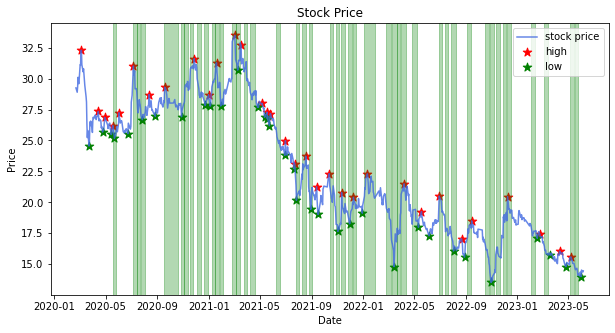

(284, 3213)

In [43]:
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=800, print_result=False, show_plot=True, save_plot=False)

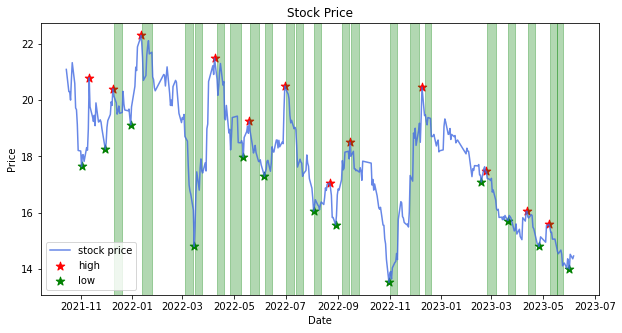

(341, 3160)

In [9]:
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=400, print_result=False, show_plot=True, save_plot=False)

Current file path is /Users/kai/Desktop/qs/data_csv_distinct_0606/000002.SZ.csv


/Users/kai/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


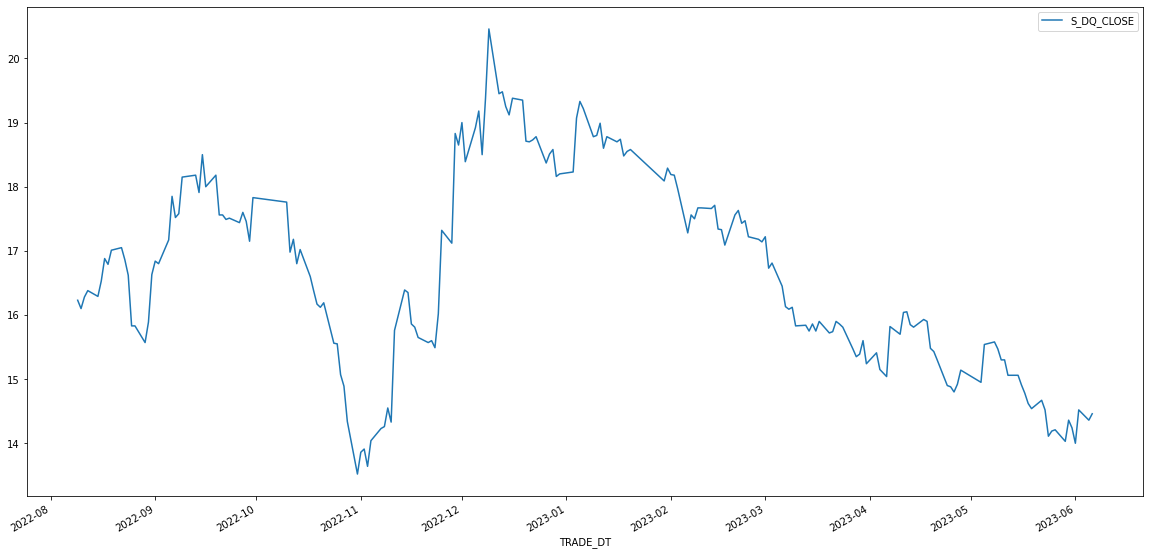

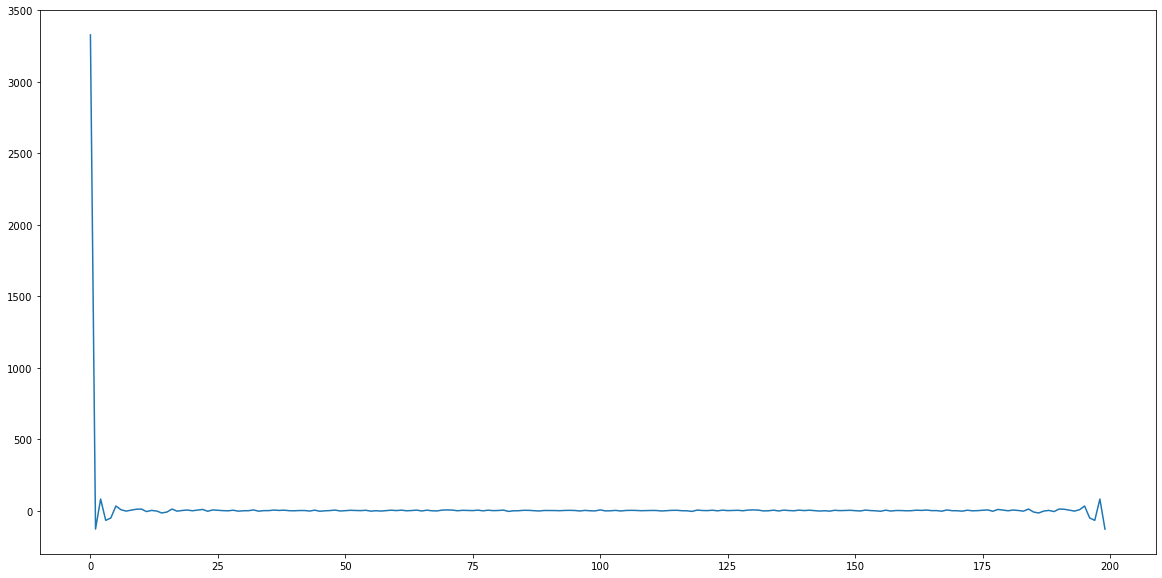

/Users/kai/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


0.004578321570314942


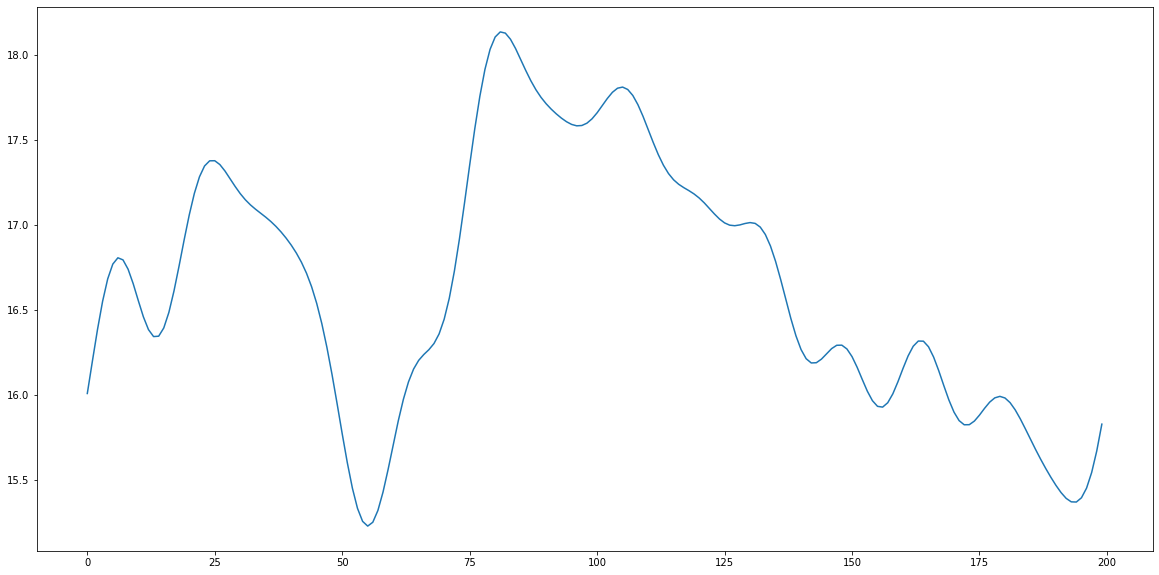

In [7]:
# 对上方得到的data曲线进行DFT变换，得到频域上的信号
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
df = hl.df_init(filename)
data = df.tail(200)
data.plot(x='TRADE_DT', y='S_DQ_CLOSE', figsize=(20, 10))
# 对data进行DFT变换
data_fft = fft(data['S_DQ_CLOSE'].values)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(data_fft)
plt.show()
# 计算频谱中的总能量，并计算高频成分所占的比例。如果高频成分所占比例较小，那么曲线就比较平滑。
# 计算频谱中的总能量
energy = (data_fft * np.conj(data_fft)).real
# 计算高频成分所占的比例
high_freq_ratio = np.sum(energy[10:]) / np.sum(energy)
print(high_freq_ratio)
# 对高频成分进行滤波
data_fft_filtered = data_fft.copy()
data_fft_filtered[15:] = 0
# 对滤波后的数据进行逆变换
data_filtered = ifft(data_fft_filtered)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(data_filtered)
plt.show()

Current file path is /Users/kai/Desktop/qs/data_csv_distinct_0606/000002.SZ.csv


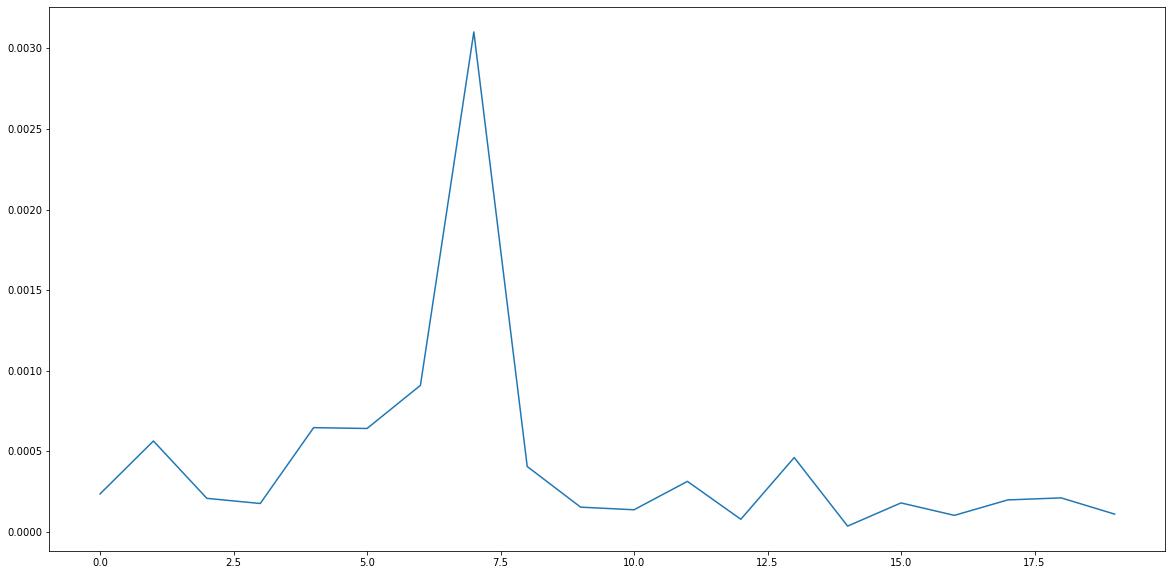

[0.00023513010005926153, 0.0005636184780725947, 0.00020757557896162605, 0.0001756033687375039, 0.0006463769545478476, 0.0006412100324198429, 0.0009089028439590118, 0.003102703903022605, 0.0004052191206344895, 0.00015290929874875144, 0.00013667934343559315, 0.00031292964523525985, 7.771422238147723e-05, 0.0004607154428991212, 3.537534577243543e-05, 0.00017918460034143307, 0.00010196373241741373, 0.00019786610934626275, 0.00021042776915944605, 0.00010980719470857438]


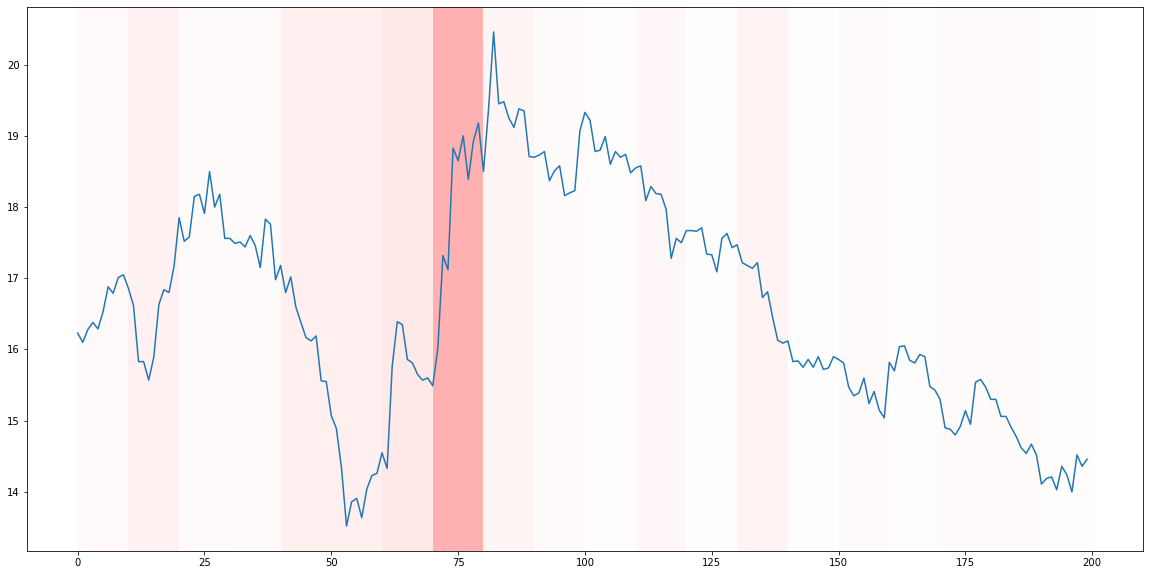

In [15]:
# 对data曲线进行DFT变换，得到频域上的信号
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
df = hl.df_init(filename)
data = df.tail(200)
# 将data等分为20份，对每份按照上述方法求的高频成分所占比例
n = 20
data_list = np.array_split(data, n)
high_freq_ratio_list = []
for temp_data in data_list:
    data_fft = fft(temp_data['S_DQ_CLOSE'].values)
    energy = (data_fft * np.conj(data_fft)).real
    high_freq_ratio = np.sum(energy[3:]) / np.sum(energy)
    high_freq_ratio_list.append(high_freq_ratio)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(high_freq_ratio_list)
plt.show()
print(high_freq_ratio_list)
# 使用plt.axvspan将高频成分占比可视化到data曲线上，高频占比越高的区域颜色越深
plt.figure(figsize=(20, 10))
plt.plot(data['S_DQ_CLOSE'].values)
for i in range(len(high_freq_ratio_list)):
    plt.axvspan(i * 10, (i + 1) * 10, facecolor='r',
                alpha=high_freq_ratio_list[i] * 100)